In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.manifold import TSNE

from matplotlib.colors import ListedColormap

import spacy as sp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Loading the dataset, and creating the corpus and storing the titles:

In [2]:
df = pd.read_excel('dataset.xlsx')

corpus, titles = [], []

for text in df['Abstract']:
    corpus.append(str(text))
        
for title in df['Article Title']:
    titles.append(str(title))

Creating the TF-IDF matrix:

In [3]:
nlp = sp.load('en_core_web_sm')

unwanted_pipes = ["ner", "parser"]

def spacy_tokenizer(doc):
  with nlp.disable_pipes(*unwanted_pipes):
    return [t.lemma_ for t in nlp(doc) if \
            not t.is_punct and \
            not t.is_space and \
            not t.is_stop and \
            t.is_alpha]

vectorizer = TfidfVectorizer(tokenizer=spacy_tokenizer, token_pattern=None)
features = vectorizer.fit_transform(corpus)
words = vectorizer.get_feature_names_out()

df_tfidf = pd.DataFrame(features.toarray(), columns=words)

Plotting the words with the highest TF-IDF value in each document:

In [4]:
def TFIDF_top_words(num, top, df_tfidf):
    DF = df_tfidf.T[num].nlargest(top)
    print('Document: ' , num + 1)
    print(30*'-')
    return DF

TFIDF_top_words(10, 5, df_tfidf)

Document:  11
------------------------------


plant         0.275629
author        0.264642
objective     0.232365
rigorously    0.213194
approach      0.196365
Name: 10, dtype: float64

## SVD

Calculating the SVD of the TF-IDF matrix:

In [5]:
n_components = 10

svd = TruncatedSVD(n_components=n_components)
lsa = svd.fit_transform(features)

df_docs_topics = pd.DataFrame(lsa, columns=[f'topic_{n+1}' for n in range(n_components)])
df_words_topics = pd.DataFrame(svd.components_, index=[f'topic_{n+1}' for n in range(n_components)], columns=words).T

Sorting the words by topics matrix by topic:

In [6]:
df_words_topics.sort_values('topic_5', ascending=False).head(10)

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10
plant,-5.661973e-09,0.109728,-0.005258,0.067056,0.257230,-0.064561,0.380103,-0.009057,-0.198745,-0.279148
marine,-5.340845e-09,0.092518,-0.043500,-0.134216,0.255909,0.096560,-0.185219,-0.014827,0.530924,-0.109280
metabolite,5.211133e-09,0.073116,-0.033929,-0.130035,0.172322,-0.023576,-0.115883,0.003380,-0.003511,-0.185243
source,-7.917859e-10,0.089146,-0.069669,-0.014716,0.133290,0.021280,0.004748,0.049714,0.078504,-0.016085
antibiotic,2.032162e-09,0.052446,-0.041043,-0.071832,0.119968,-0.029726,-0.132922,-0.205886,-0.182477,0.382890
secondary,2.387316e-09,0.045776,-0.031817,-0.081352,0.117963,-0.007017,-0.081146,-0.015353,-0.000030,-0.127532
antimicrobial,2.647995e-09,0.039626,0.009929,-0.063649,0.099113,-0.024800,-0.012111,-0.102249,-0.037840,0.123027
extract,-7.262958e-10,0.073485,0.124354,-0.095358,0.091846,-0.119787,0.124541,0.151637,-0.126435,-0.027055
microorganism,3.668110e-10,0.029752,-0.028415,-0.047296,0.088925,0.005619,-0.057430,-0.016181,0.057298,-0.011875
review,-6.797879e-10,0.093573,-0.087274,0.048417,0.086889,0.094097,0.036521,-0.053162,0.055713,-0.013551


## $k$-Means

With the TF-IDF matrix, we can clusterize the data using $k$-means.

In [7]:
pipeline = make_pipeline(TruncatedSVD(n_components=n_components), KMeans(n_clusters=n_components))
pipeline.fit(features)

kmeans_clusters = pipeline.predict(features)

Plotting the data with $t$-SNE.

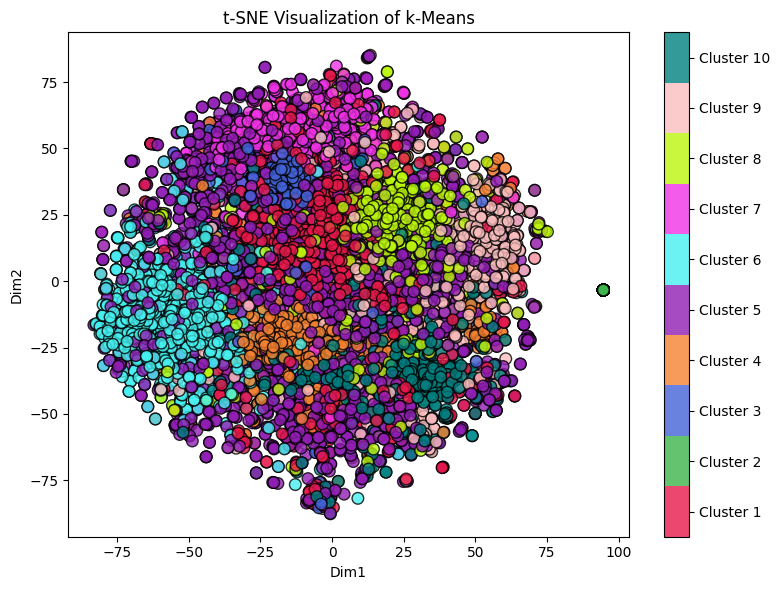

In [8]:
tsne = TSNE()
tfidf_tsne = tsne.fit_transform(features.toarray())

high_contrast_colors = [
    '#e6194b', 
    '#3cb44b', 
    '#4363d8',
    '#f58231',
    '#911eb4', 
    '#46f0f0', 
    '#f032e6', 
    '#bcf60c', 
    '#fabebe', 
    '#008080', 
    '#e6beff',
    '#9a6324', 
]

cmap = ListedColormap(high_contrast_colors[:n_components])

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    x=tfidf_tsne[:, 0],
    y=tfidf_tsne[:, 1],
    c=kmeans_clusters,
    cmap=cmap,
    alpha=0.8,
    edgecolor='black',
    s=70,
    vmin=-0.5,
    vmax=n_components-0.5
)

plt.xlabel('Dim1')
plt.ylabel('Dim2')
plt.title('t-SNE Visualization of k-Means')

cbar = plt.colorbar(scatter, ticks=np.arange(n_components))
cbar.set_ticklabels([f'Cluster {i+1}' for i in range(n_components)])

plt.tight_layout()

plt.show()